In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import os

In [3]:
Train_dir = 'C:/Users/Hrishikesh M Rao/Documents/archive (1)/ck/CK+48'
emotions_loc = 'C:/Users/Hrishikesh M Rao/Documents/archive (1)/ck/CK+48'

In [4]:
images = []
labels = []
i=0
for emotions in os.listdir(Train_dir):
    emotion_path = os.path.join(emotions_loc,emotions)
    for filename in os.listdir(emotion_path):
        if filename.endswith('.png'):
            image_path = os.path.join(emotion_path, filename)
            image = Image.open(image_path)
            desired_size = (224, 224)
            image = image.resize(desired_size)
            image = np.array(image)
            image = image / 255.0
            images.append(image)
            label = np.zeros(7)
            label[i] = 1
            labels.append(label)
    i+=1       

The shape of the images list is = (981, 224, 224)
The size of the images list is = 49222656
[1. 0. 0. 0. 0. 0. 0.]


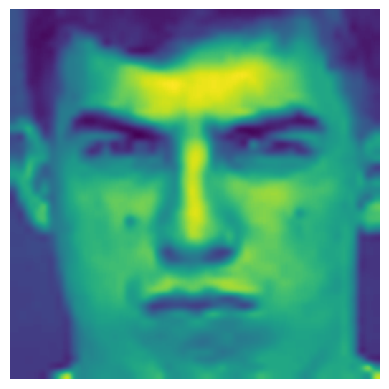

In [5]:
print("The shape of the images list is = "+str(np.shape(images)))
print("The size of the images list is = "+str(np.size(images)))

print(labels[i])
i = 98 
plt.imshow(images[i])
plt.axis('off')  # Hide axis labels and ticks
plt.show()


## Reshape the images and label matrix as necessary

In [6]:

images = np.transpose(images, (1, 2, 0))
images = images.reshape(224*224,981)
labels = np.array(labels)
labels = np.transpose(labels,(1,0))

# Shuffle the dataset
num_samples = images.shape[1]
indices = np.arange(num_samples)
np.random.shuffle(indices)
images = images[:,indices]
labels = labels[:,indices]



[0. 0. 0. 1. 0. 0. 0.]


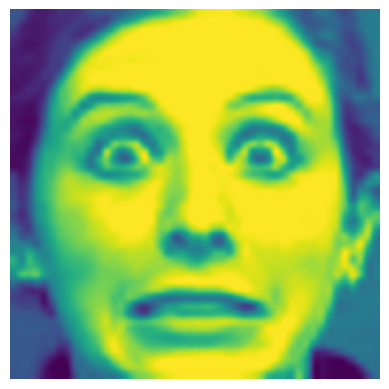

In [7]:
print(labels[:,i])
i = 1  # Change this to the index of the image you want to plot

# Select the column corresponding to the ith image
selected_image = images[:, i]

# Reshape the selected image back to its original shape (224x224)
original_shape_image = selected_image.reshape(224, 224)

plt.imshow(original_shape_image)
plt.axis('off')  # Hide axis labels and ticks
plt.show()

## Normalizer

In [8]:
def Normalise(parameter):

    mean = np.mean(parameter)
    std = np.std(parameter)
    parameter = (parameter-mean)/(std)
    
    return parameter

def MinMax(parameter):
    
    min = np.min(parameter)
    max = np.max(parameter)
    deviation = max - min
    parameter = (parameter-min)/(deviation)
    
    return parameter

In [9]:
images = Normalise(images)
#images = MinMax(images)

images_Df=pd.DataFrame(images)
labels_Df=pd.DataFrame(labels)
images_Df

,0,1,2,3,4,5,6,7,8,9,...,971,972,973,974,975,976,977,978,979,980
0,-1.369645,-0.865549,-0.388702,-0.974543,-0.320581,-0.075345,0.306132,-1.274276,0.292508,-1.287900,...,-0.824677,-0.279709,-1.601256,-0.334205,0.020024,-1.587632,-0.633938,-1.560384,-0.061721,-1.138033
1,-1.369645,-0.865549,-0.429575,-0.988167,-0.347830,-0.129842,0.306132,-1.287900,0.292508,-1.287900,...,-0.824677,-0.279709,-1.601256,-0.361454,-0.020849,-1.601256,-0.633938,-1.533135,-0.061721,-1.138033
2,-1.383269,-0.865549,-0.484072,-1.015416,-0.402326,-0.252460,0.306132,-1.328772,0.292508,-1.287900,...,-0.824677,-0.279709,-1.601256,-0.415951,-0.088970,-1.601256,-0.633938,-1.519511,-0.061721,-1.151658
3,-1.410518,-0.865549,-0.579441,-1.069912,-0.497696,-0.456823,0.306132,-1.383269,0.292508,-1.274276,...,-0.824677,-0.279709,-1.587632,-0.511320,-0.225212,-1.614881,-0.633938,-1.478639,-0.061721,-1.178906
4,-1.437766,-0.851925,-0.729307,-1.138033,-0.633938,-0.742932,0.306132,-1.451390,0.292508,-1.260651,...,-0.824677,-0.266084,-1.574008,-0.620314,-0.415951,-1.642129,-0.633938,-1.410518,-0.048097,-1.206155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50171,-0.102594,-0.783804,-1.560384,-1.287900,0.306132,0.360629,0.919221,-1.301524,0.946470,0.646737,...,-0.702059,-1.001791,-1.723874,-0.565817,-0.879174,0.142642,-0.742932,-0.579441,-1.029040,-1.560384
50172,-0.157091,-0.661186,-1.628505,-1.233403,0.292508,0.360629,0.823852,-1.315148,0.946470,0.646737,...,-0.702059,-0.988167,-1.710250,-0.552193,-0.865549,0.115393,-0.742932,-0.579441,-1.042664,-1.614881
50173,-0.184339,-0.579441,-1.669377,-1.192530,0.292508,0.374253,0.755731,-1.328772,0.946470,0.646737,...,-0.702059,-0.988167,-1.710250,-0.552193,-0.851925,0.088145,-0.742932,-0.579441,-1.069912,-1.655753
50174,-0.211588,-0.511320,-1.683002,-1.178906,0.292508,0.374253,0.728483,-1.342397,0.946470,0.646737,...,-0.702059,-0.988167,-1.710250,-0.552193,-0.851925,0.074521,-0.742932,-0.579441,-1.069912,-1.669377


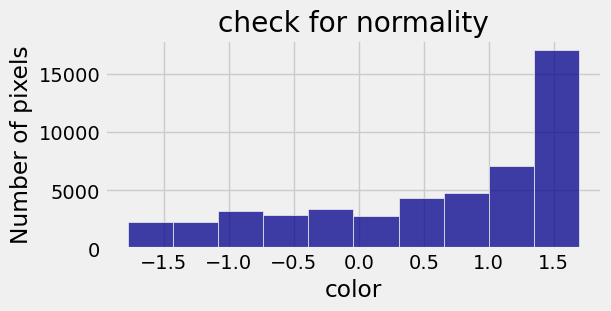

In [10]:

import matplotlib.style as style
style.use('fivethirtyeight')

fig = plt.figure(constrained_layout=True, figsize=(6,3))
sns.histplot(images_Df.loc[:,1], kde=False, color='darkblue', bins=10)
plt.xlabel('color')  # Add a label to the x-axis.
plt.ylabel('Number of pixels')  # Add a label to the y-axis.
plt.title('check for normality')  # Add a title to the plot.

plt.show()


In [11]:
images_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50176 entries, 0 to 50175
Columns: 981 entries, 0 to 980
dtypes: float64(981)
memory usage: 375.5 MB


In [12]:
images_Df.describe()

,0,1,2,3,4,5,6,7,8,9,...,971,972,973,974,975,976,977,978,979,980
count,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,...,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000
mean,0.182247,0.610924,-0.238729,-0.465230,0.288205,-0.704777,0.723625,0.288549,0.720598,-0.210145,...,0.382284,0.610526,0.276813,0.324997,0.096159,-0.951291,0.097912,0.367753,0.362087,0.130876
std,0.924692,1.034048,1.013389,0.996104,0.928017,0.847550,0.581387,1.075950,0.579761,0.547721,...,0.957422,1.173373,1.150575,1.025028,0.888025,0.587363,0.839502,1.008818,1.276182,1.199418
min,-1.683002,-1.778371,-1.778371,-1.778371,-1.778371,-1.778371,-1.342397,-1.778371,-1.383269,-1.533135,...,-1.778371,-1.778371,-1.778371,-1.778371,-1.778371,-1.778371,-1.737498,-1.764747,-1.710250,-1.778371
25%,-0.388702,-0.252460,-1.274276,-1.437766,-0.293333,-1.465014,0.278884,-0.484072,0.278884,-0.552193,...,-0.470447,-0.388702,-0.865549,-0.565817,-0.702059,-1.410518,-0.633938,-0.511320,-1.124409,-1.056288
50%,0.156266,0.946470,-0.238836,-0.443199,0.306132,-0.879174,0.728483,0.415126,0.728483,-0.116218,...,0.455998,1.109960,0.551368,0.401502,0.210763,-0.988167,0.033648,0.455998,0.755731,0.278884
75%,0.946470,1.559559,0.551368,0.387877,1.041839,-0.061721,1.259827,1.273451,1.259827,0.183514,...,1.273451,1.695801,1.327948,1.287075,0.823852,-0.593065,0.769355,1.355196,1.695801,1.287075
max,1.695801,1.695801,1.695801,1.450565,1.695801,1.695801,1.668553,1.695801,1.641304,1.164457,...,1.695801,1.695801,1.695801,1.695801,1.695801,1.150833,1.695801,1.695801,1.695801,1.695801


## Initialise W and b for every node of each layer

In [13]:
def initialize_parameters(layers): 
    parameters = {}
    L = len(layers)
    for l in range(1, L):
        
        parameters['W' + str(l)] = np.random.randn(layers[l],layers[l-1])
        
        parameters['b' + str(l)] = np.zeros((layers[l],1))
  
    return parameters

## The Activation Fuctions

In [14]:
def sigmoid(Z):
    a = 1/(1+np.exp(-Z))
    return a

def relu(Z):
    a = np.maximum(0,Z)
    return a

def soft_max(Z):
    exp = np.exp(Z-np.max(Z,axis=0))
    a = exp/(np.sum(exp,axis=0,keepdims=True))
    return a

## Propagate forward

In [15]:
def forward_propagation(images,parameters):
    
    cache = {}
    L= int(len(parameters)/2)
    
    cache['Z'+str(1)] = (np.dot(parameters['W'+str(1)],images))+parameters['b'+str(1)]
    cache['A'+str(1)] = relu(cache['Z'+str(1)])
    cache['A'+str(1)] = MinMax(cache['A'+str(1)])
    
    for l in range(2,L):
        cache['Z'+str(l)] = (np.dot(parameters['W'+str(l)],cache['A'+str(l-1)]))+parameters['b'+str(l)]
        cache['A'+str(l)] = relu(cache['Z'+str(l)])
        cache['A'+str(l)] = MinMax(cache['A'+str(l)])
        
    cache['Z'+str(L)] = (np.dot(parameters['W'+str(L)],cache['A'+str(L-1)]))+parameters['b'+str(L)]
    cache['A'+str(L)] = soft_max(cache['Z'+str(L)])
    
    cache['A0'] = images
    A4 = cache['A'+str(L)]

    return A4,cache


## Loss Function

In [16]:
def compute_loss(A4,labels,epsilon):
    
    m = labels.shape[1]
    cost = np.sum(-(np.sum(labels*np.log(A4+epsilon),axis=0,keepdims=False)))/m
    #cost = -np.sum(np.sum(np.multiply(labels, np.log(A4)) + np.multiply((1 - labels), np.log(1 - A4)),axis=1),axis=0)/m
    
    return cost

In [17]:
def backward_propagation(images, labels, cache, parameters,epsilon):
    
    grads={}
    m=images.shape[1]
    L = int(len(cache)/2)
    
    grads['dZ'+str(L)] =  (cache['A'+str(L)]-labels)
    grads['dW'+str(L)] = np.dot(grads['dZ'+str(L)],cache['A'+str(L-1)].T)/m
    grads['db'+str(L)] = np.sum(grads['dZ'+str(L)],axis=1,keepdims=True)/m #sum by the rows of dZ with keepdims=True 
    grads['dA'+str(L-1)] = np.dot(parameters['W'+str(L)].T,grads['dZ'+str(L)])
    
    for l in range(L-1,0,-1):
        grads['dZ'+str(l)] = np.where(cache['Z'+str(l)]>0,1,0)*grads['dA'+str(l)]
        grads['dA'+str(l-1)] = np.dot(parameters['W'+str(l)].T,grads['dZ'+str(l)])
        grads['dW'+str(l)] = np.dot(grads['dZ'+str(l)],cache['A'+str(l-1)].T)/m
        grads['db'+str(l)] = np.sum(grads['dZ'+str(l)],axis=1,keepdims=True)/m #sum by the rows of dZ with keepdims=True
    
    return grads

## Update Parameters

In [18]:
def update_parameters(parameters, grads, learning_rate):
    
    L = int(len(parameters)/2)
    for l in range(L):
        
        parameters['W'+str(l+1)]= (parameters['W'+str(l+1)])-(learning_rate*grads['dW'+str(l+1)])

        parameters['b'+str(l+1)]= (parameters['b'+str(l+1)])-(learning_rate*grads['db'+str(l+1)])
        
    return parameters

In [19]:
def calculate_accuracy(true_labels, A4):
    
    # Ensure that the input arrays have the same shape
    assert true_labels.shape == A4.shape, "Input shapes do not match"
 
    # Calculate the number of correct predictions
    mask1 = (np.abs(true_labels-A4)<=0.25)
    mask2 = (np.all(mask1,axis=0))
    
    '''
    tl_Df = pd.DataFrame(true_labels)
    print(tl_Df)
    A4_Df = pd.DataFrame(A4)
    print(A4_Df)
    '''
    # Count the total number of times 1 appears using the mask
    num_correct = np.sum(mask2)
    
    # Calculate the total number of samples
    total_samples = true_labels.shape[1]

    # Calculate accuracy
    accuracy = (num_correct*100) / total_samples
    
    return accuracy

## Combine all the functions to create a working model

In [22]:
def predictor(images, labels, learning_rate, num_iterations=15000, print_cost = True, epsilon = 1e-15):
    grads = {}
    costs = []
    layers = [images.shape[0],10,10,10,labels.shape[0]]
    # Initialse w and b
    parameters=initialize_parameters(layers)
    
    for i in range(0, num_iterations):
        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        A4, cache = forward_propagation(images, parameters)
        
        # Loss
        cost = compute_loss(A4, labels, epsilon)

        # Backward propagation.
        grads = backward_propagation(images, labels, cache, parameters,epsilon)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            accuracy = calculate_accuracy(labels, A4)
            print("Accuracy:", accuracy, "%")  
                 
        # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters 

In [23]:
predictor(images, labels, learning_rate = 0.01)




Cost after iteration 0: 2.1955712572896897
Accuracy: 0.0 %
Cost after iteration 1000: 1.240763208011794
Accuracy: 0.0 %
Cost after iteration 2000: 1.1826348250820358
Accuracy: 5.198776758409786 %
Cost after iteration 3000: 1.1154680305868307
Accuracy: 11.213047910295616 %
Cost after iteration 4000: 1.0605012627723769
Accuracy: 16.00407747196738 %
Cost after iteration 5000: 1.0160555927487243
Accuracy: 20.89704383282365 %
Cost after iteration 6000: 0.9797912995713882
Accuracy: 23.547400611620795 %
Cost after iteration 7000: 0.9482008498585554
Accuracy: 26.19775739041794 %


KeyboardInterrupt: 